In [38]:
import pandas as pd
import string
from glove import Glove

In [64]:
# columns to use
cols=['description', 'points']

# import data
reviews_1 = pd.read_csv('../../data/wine-reviews/winemag-data_first150k.csv', index_col=False, usecols=cols)
reviews_2 = pd.read_csv('../../data/wine-reviews/winemag-data-130k-v2.csv', index_col=False, usecols=cols)

print("Number of entries in dataset 1: %s" %reviews_1.shape[0])
print("Number of entries in dataset 2: %s" %reviews_2.shape[0])

duplicates = set(reviews_1.description).intersection(set(reviews_2.description))

print("\nNumber of duplicate entries across datasets: %s" % len(duplicates))

# concatenate and drop duplicates
data = pd.concat([reviews_1,reviews_2])
data.drop_duplicates(inplace=True)

print("\nNumber of unique reviews: %s" % data.shape[0])

data.head()

Number of entries in dataset 1: 150930
Number of entries in dataset 2: 129971

Number of duplicate entries across datasets: 48346

Number of unique reviews: 169461


,description,points
0,This tremendous 100% varietal wine hails from ...,96
1,"Ripe aromas of fig, blackberry and cassis are ...",96
2,Mac Watson honors the memory of a wine once ma...,96
3,"This spent 20 months in 30% new French oak, an...",96
4,"This is the top wine from La Bégude, named aft...",95


In [135]:
punc_remove = string.punctuation
punc_remove = punc_remove.replace('%', '')
table = str.maketrans(dict.fromkeys(punc_remove))

# lowercase
data['description_test'] = data.description_test.str.lower()
# remove punctuation
data['description_test'] = data.description_test.str.translate(table)
# replace percentage sign
data['description_test'] = data.description_test.str.replace('%', ' percent')
# split words
data['description_test'] = data.description_test.str.split()

In [137]:
data.head()

,description,points,description_test
0,This tremendous 100% varietal wine hails from ...,96,"[this, tremendous, 100, percent, varietal, win..."
1,"Ripe aromas of fig, blackberry and cassis are ...",96,"[ripe, aromas, of, fig, blackberry, and, cassi..."
2,Mac Watson honors the memory of a wine once ma...,96,"[mac, watson, honors, the, memory, of, a, wine..."
3,"This spent 20 months in 30% new French oak, an...",96,"[this, spent, 20, months, in, 30, percent, new..."
4,"This is the top wine from La Bégude, named aft...",95,"[this, is, the, top, wine, from, la, bégude, n..."


In [254]:
import tensorflow as tf
import numpy as np
import collections
from collections import Counter
import math
import random

In [241]:
def create_vocabulary(documents):
    """Unique words and counts"""
    vocabulary = Counter()

    for row in documents:
        vocabulary.update(row)
        
    return vocabulary

documents = list(data.description_test)
vocabulary = create_vocabulary(documents)
vocabulary_size = len(vocabulary)

print("Number of unique words: %s" % vocabulary_size)

Number of unique words: 58541


In [242]:
def top_vocabulary(vocabulary, n_words=10000):
    """Limit vocabulary to highest occurring words and create IDs."""
    vocabulary_n = list(dict(vocabulary.most_common(n_words - 1)).keys())
    vocabulary_n.append('UNK') # placeholder for rare words
    
    vocabulary_n = dict(zip(vocabulary_n, random.sample(range(0, n_words+1), n_words)))
            
    return vocabulary_n

vocabulary_n = top_vocabulary(vocabulary)

In [243]:
def map_vocabulary(vocabulary, map_table):
    """Map vocabulary words to IDs"""
    vocabulary_map_table = dict.fromkeys(vocabulary.keys(), 0)
    for word in vocabulary:
        if word not in map_table:
            vocabulary_map_table[word] = map_table['UNK']
        else:
            vocabulary_map_table[word] = map_table[word]
            
    return vocabulary_map_table
    
vocabulary_map_table = map_vocabulary(vocabulary, vocabulary_n)

In [250]:
def map_documents(documents, vocabulary_map_table):
    """Map documents to integer word IDs"""
    documents_mapped = [[vocabulary_map_table[word] for word in doc] for doc in documents]
    
    return documents_mapped
    
documents_mapped = map_documents(documents, vocabulary_map_table)         

In [262]:
review_index = 0 # keep track of training batches
word_index = 0
total_num_words = sum([len(doc) for doc in documents_mapped])

In [263]:
total_num_words

6868514

In [300]:
def generate_batch(documents_mapped, batch_size, num_skips, skip_window):
    
    global review_index
    global word_index
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # span considers window on both sides of target word
    # we could potentially consider a full sentence or review
    # as the context, but keeping it simpler for now
    span = 2 * skip_window + 1 
    
    # init buffer (context and target words)
    buffer = collections.deque(maxlen=span)
    
    # go back to first review if no more reviews left
    if review_index >= len(documents_mapped):
        review_index = 0
    
    # make sure there are enough words for skip-gram
    # could consider moving to next review instead of recycling words
    if word_index + span > len(documents_mapped[word_index]):
        word_index = len(documents_mapped[word_index]) - span
    
    # new skip-gram
    buffer.extend(documents_mapped[review_index][word_index:word_index + span])
        
    for i in range(batch_size // num_skips):
        # skip_window is the same as index of target word
        context_words = [w for w in range(span) if w != skip_window]
        # randomly select context word indices to use
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            # target word
            batch[i * num_skips + j] = buffer[skip_window]
            # context word
            labels[i * num_skips + j, 0] = buffer[context_word]
        
        # add next words / new review for skips
        if word_index + span == len(documents_mapped[word_index]):
            # next review
            word_index = 0
            review_index += 1
            # start at the beginning if non left
            if review_index >= len(documents_mapped):
                review_index = 0
            
            buffer.extend(documents_mapped[review_index][word_index:word_index + span])
            
            word_index += span
        else:
            # add next word in review
            buffer.append(documents_mapped[review_index][word_index])
            word_index += 1
            
    return batch, labels
            
batch_size = 50
num_skips = 5
skip_window = 3
test_batch, test_labels = generate_batch(documents_mapped, batch_size, num_skips, skip_window)       

In [301]:
assert test_batch.shape[0] == batch_size

In [302]:
print("Target sample:")
print(test_batch[:10])
print("\nContext Sample:")
print(test_labels[:10])

Target sample:
[1654 1654 1654 1654 1654 5564 5564 5564 5564 5564]

Context Sample:
[[2843]
 [6133]
 [6621]
 [9040]
 [5564]
 [1654]
 [8424]
 [6621]
 [6133]
 [2843]]


In [304]:
embedding_size = 64

batch_size = 50
num_skips = 5
skip_window = 3

num_sampled = 32 # number of negative examples to sample

In [309]:
graph = tf.Graph()

with graph.as_default():
    
    # input data
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=batch_size) # target
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1]) # context (what we want to predict)
        
    with tf.name_scope('embeddings'):
        # embedding weights
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
    # hidden layer weights
    with tf.name_scope('weights'):
        nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                      stddev=1.0 / math.sqrt(embedding_size)))
    # hidden layers biases
    with tf.name_scope('biases'):
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
        
    # NCE because softmax is too expensive
    # is it a good or a corrupt pair (context and target)?
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights, 
                biases=nce_biases, 
                labels=train_labels, 
                inputs=embed, 
                num_sampled=num_sampled, 
                num_classes=vocabulary_size))
        
    # for viz
    tf.summary.scalar('loss', loss)
    
    # SGD - minimize loss on train data (see loss above)
    # Learning Rate = 1.0 (don't care about overfitting)
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
#     valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid)

    # summary data
    merged = tf.summary.merge_all()
    
    # init variables
    init = tf.global_variables_initializer()
    
    # saver
    saver = tf.train.Saver()    

In [314]:
num_steps = 10001 # number of unique words

with tf.Session(graph=graph) as session:
    
    writer = tf.summary.FileWriter('word2vec', session.graph)
    
    init.run()
    print('Initialized')
    
    average_loss = 0
    
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(documents_mapped, batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        run_metadata = tf.RunMetadata()
        
        _, summary, loss_val = session.run(
            [optimizer, merged, loss], 
            feed_dict=feed_dict, 
            run_metadata=run_metadata)
        
        average_loss += loss_val
        
        writer.add_summary(summary, step)
        
        if step == (num_steps - 1):
            writer.add_run_metadata(run_metadata, 'step%d' % step)
            
        if step % 200 == 0:
            if step > 0:
                average_loss /= 200
                
            print('Average loss at step', step, ': ', average_loss)
        
    final_embeddings = normalized_embeddings.eval()

    saver.save(session, 'word2vec/model.ckpt')
    
writer.close()

Initialized
Average loss at step 0 :  144.81646728515625
Average loss at step 200 :  114.52941194534301
Average loss at step 400 :  90.5319485505104
Average loss at step 600 :  79.99003164521837
Average loss at step 800 :  74.28330289565285
Average loss at step 1000 :  65.91252899464183
Average loss at step 1200 :  62.91075384618323
Average loss at step 1400 :  58.928255007863115
Average loss at step 1600 :  57.16950996839107
Average loss at step 1800 :  51.89650005142506
Average loss at step 2000 :  53.44111066550218
Average loss at step 2200 :  47.70852129963489
Average loss at step 2400 :  44.77761455025809
Average loss at step 2600 :  42.574520873807195
Average loss at step 2800 :  40.22343735789399
Average loss at step 3000 :  42.19433531248344
Average loss at step 3200 :  37.88306487444098
Average loss at step 3400 :  36.50781720901545
Average loss at step 3600 :  37.41391934988417
Average loss at step 3800 :  33.60566375148126
Average loss at step 4000 :  32.52641398354897
Avera

In [332]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')

    plt.savefig(filename)

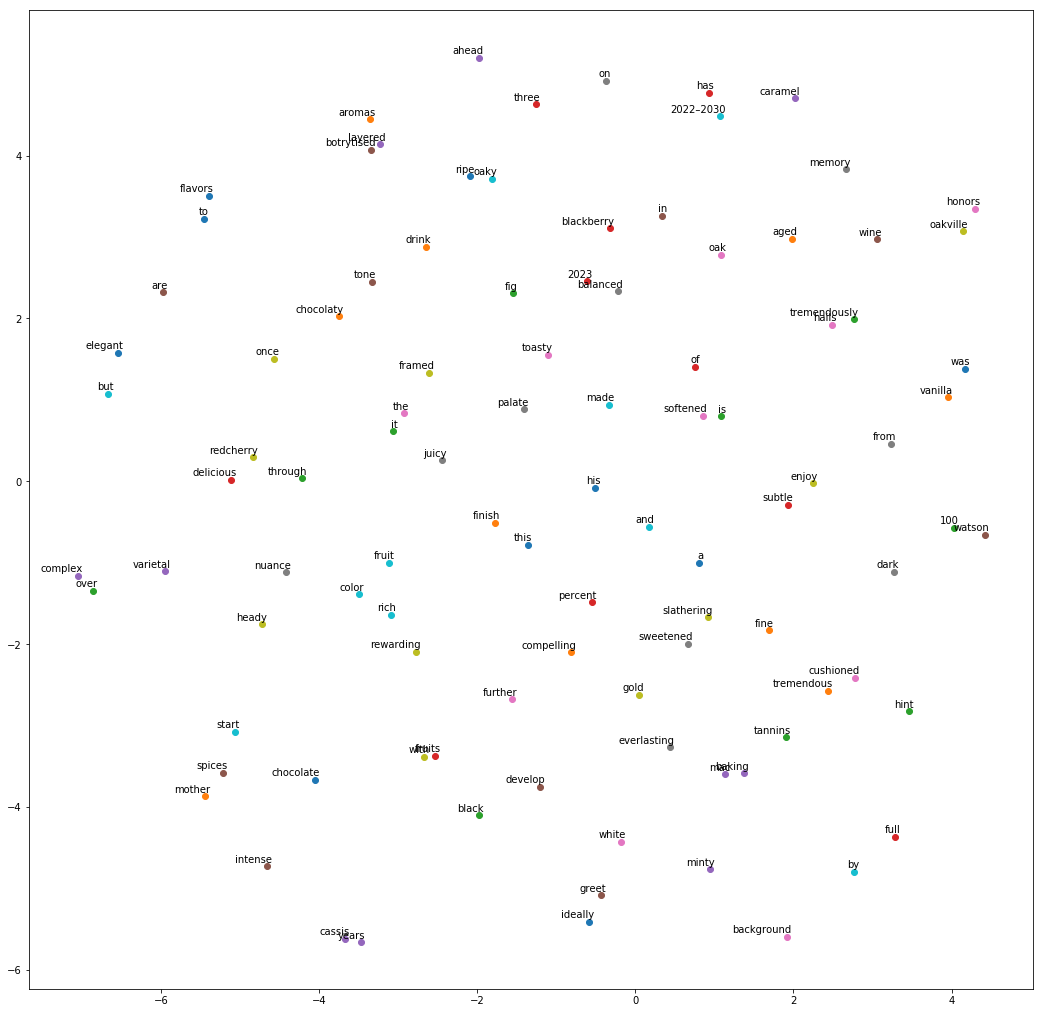

In [337]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 100
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [list(vocabulary_map_table.keys())[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels, 'word2vec/tsne.png')
# plt.show()

In [342]:
assert final_embeddings.shape[0] == len(vocabulary)

In [343]:
# documents_mapped
# data.points

In [361]:
print("Longest review has %d words" % data.description_test.apply(len).max())
print("On average review has %d words" % data.description_test.apply(len).mean())

# restrict review length
print("95 percent quantile review number of words: %d" % data.description_test.apply(len).quantile(0.95))

Longest review has 135 words
On average review has 40 words
95 percent quantile review number of words: 61


In [362]:
max_review_length = 61

In [366]:
train_index = 0
test_index = 0

def generate_train_batch(documents_mapped, output, batch_size):
    
    global train_index
    
    batch = np.ndarray(shape=(batch_size, max_review_length), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    for i in range(batch_size):
        batch[i] = documents_mapped[i]
        labels[i] = output[i]
        train_index += 1
        
        if train_index >= len(documents_mapped):
            train_index = 0
            
    return batch, labels


def generate_test_batch(documents_mapped, output, batch_size):
    
    global test_index
    
    batch = np.ndarray(shape=(batch_size, max_review_length), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    for i in range(batch_size):
        batch[i] = documents_mapped[i]
        labels[i] = output[i]
        test_index += 1
        
        if test_index >= len(documents_mapped):
            test_index = 0
            
    return batch, labels

In [369]:
batch_size = 24
h_units = 64
iterations = 50000
learning_rate = 0.01

In [ ]:
graph = tf.Graph()

with graph.as_default():
    
    # input data
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size, max_review_length]) # review
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1]) # review points (predict)
        
    with tf.name_scope('embeddings'):
        # embedding weights
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(final_embeddings, train_inputs)
    
    with tf.name_scope('LSTM_1'):
        lstmCell = tf.contrib.rnn.BasicLSTMCell(h_units)
        # drop out
        lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.9)
        # unroll
        value, _ = tf.nn.dynamic_rnn(lstmCell, embed, dtype=tf.float32)
    
    # output layer weights
    with tf.name_scope('weights'):
        output_weights = tf.Variable(tf.truncated_normal([h_units, 1],
                      stddev=1.0 / math.sqrt(embedding_size)))
    # output layers biases
    with tf.name_scope('bias'):
        output_bias = tf.Variable(tf.zeros([1]))
        
    value = tf.transpose(value, [1, 0])
    last = tf.gather(value, int(value.get_shape()[0]) - 1)
    
    predictions = tf.add(tf.matmul(last, output_weights), output_bias)
    
    # MSE since linear output
    with tf.name_scope('loss'):
        loss = tf.lossses.mean_squared_error(
            labels=train_labels, 
            predictions=predictions)
        
#     # for viz
#     tf.summary.scalar('loss', loss)
    
#     # SGD - minimize loss on train data (see loss above)
#     # Learning Rate = 1.0 (don't care about overfitting)
#     with tf.name_scope('optimizer'):
#         optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
#     norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
#     normalized_embeddings = embeddings / norm
# #     valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid)

#     # summary data
#     merged = tf.summary.merge_all()
    
#     # init variables
#     init = tf.global_variables_initializer()
    
#     # saver
#     saver = tf.train.Saver()    

In [367]:
# documents_mapped